# Splines in PyMC3

- [Question](https://discourse.pymc.io/t/spline-regression-in-pymc3/6235) on PyMC Discourse
- *Statistical Rethinking* example in [PyMC3](https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_04.ipynb) and [Stan](https://vincentarelbundock.github.io/rethinking2/04.html)
- My [post](https://joshuacook.netlify.app/post/pymc3-spline/) with additional visualization and explination

In [1]:
from pathlib import Path

import arviz as az
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm

from patsy import dmatrix

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

gg.theme_set(gg.theme_minimal())

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Introduction

**Use the text from my blog post!!! Don't re-write from scratch dummy!!**

Note that this is not a complete tutorial on splines, only on their implementation in PyMC3.
Point to other sources (Statistical Learning by Tibshirani and Hastings).

Also need to install `python-graphviz` if want to visualize the graph of the model.

Note data aquired from [Richard McElreath's](https://xcelab.net/rm/) [repository](https://github.com/rmcelreath/rethinking) for his excellent Bayesian modeling book [Statistical Rethinking](http://xcelab.net/rm/statistical-rethinking/).
Also note that the example is based off of an example from the book (I think...).

Explain that I use 'plotnine' and link to 'ggplot' doc/book and tutorials by Real Python.

## Replicate the example from *Statistical Rethinking*

In [3]:
try:
    d = pd.read_csv(Path("..", "data", "cherry_blossoms.csv"), sep=";")
except FileNotFoundError:
    blossoms_data_path = (
        "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/cherry_blossoms.csv"
    )
    d = pd.read_csv(blossoms_data_path, sep=";")

# nans are not treated as in the book
d.dropna().describe()

,year,doy,temp,temp_upper,temp_lower
count,787.000000,787.00000,787.000000,787.000000,787.000000
mean,1533.395172,104.92122,6.100356,6.937560,5.263545
std,291.122597,6.25773,0.683410,0.811986,0.762194
min,851.000000,86.00000,4.690000,5.450000,2.610000
25%,1318.000000,101.00000,5.625000,6.380000,4.770000
50%,1563.000000,105.00000,6.060000,6.800000,5.250000
75%,1778.500000,109.00000,6.460000,7.375000,5.650000
max,1980.000000,124.00000,8.300000,12.100000,7.740000


In [4]:
d2 = d.dropna(subset=["doy"]).reset_index(drop=True)
d2.head(n=10)

,year,doy,temp,temp_upper,temp_lower
0,812,92.0,NaN,NaN,NaN
1,815,105.0,NaN,NaN,NaN
2,831,96.0,NaN,NaN,NaN
3,851,108.0,7.38,12.10,2.66
4,853,104.0,NaN,NaN,NaN
5,864,100.0,6.42,8.69,4.14
6,866,106.0,6.44,8.11,4.77
7,869,95.0,NaN,NaN,NaN
8,889,104.0,6.83,8.48,5.19
9,891,109.0,6.98,8.96,5.00


In [5]:
d2.shape

(827, 5)

In [6]:
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

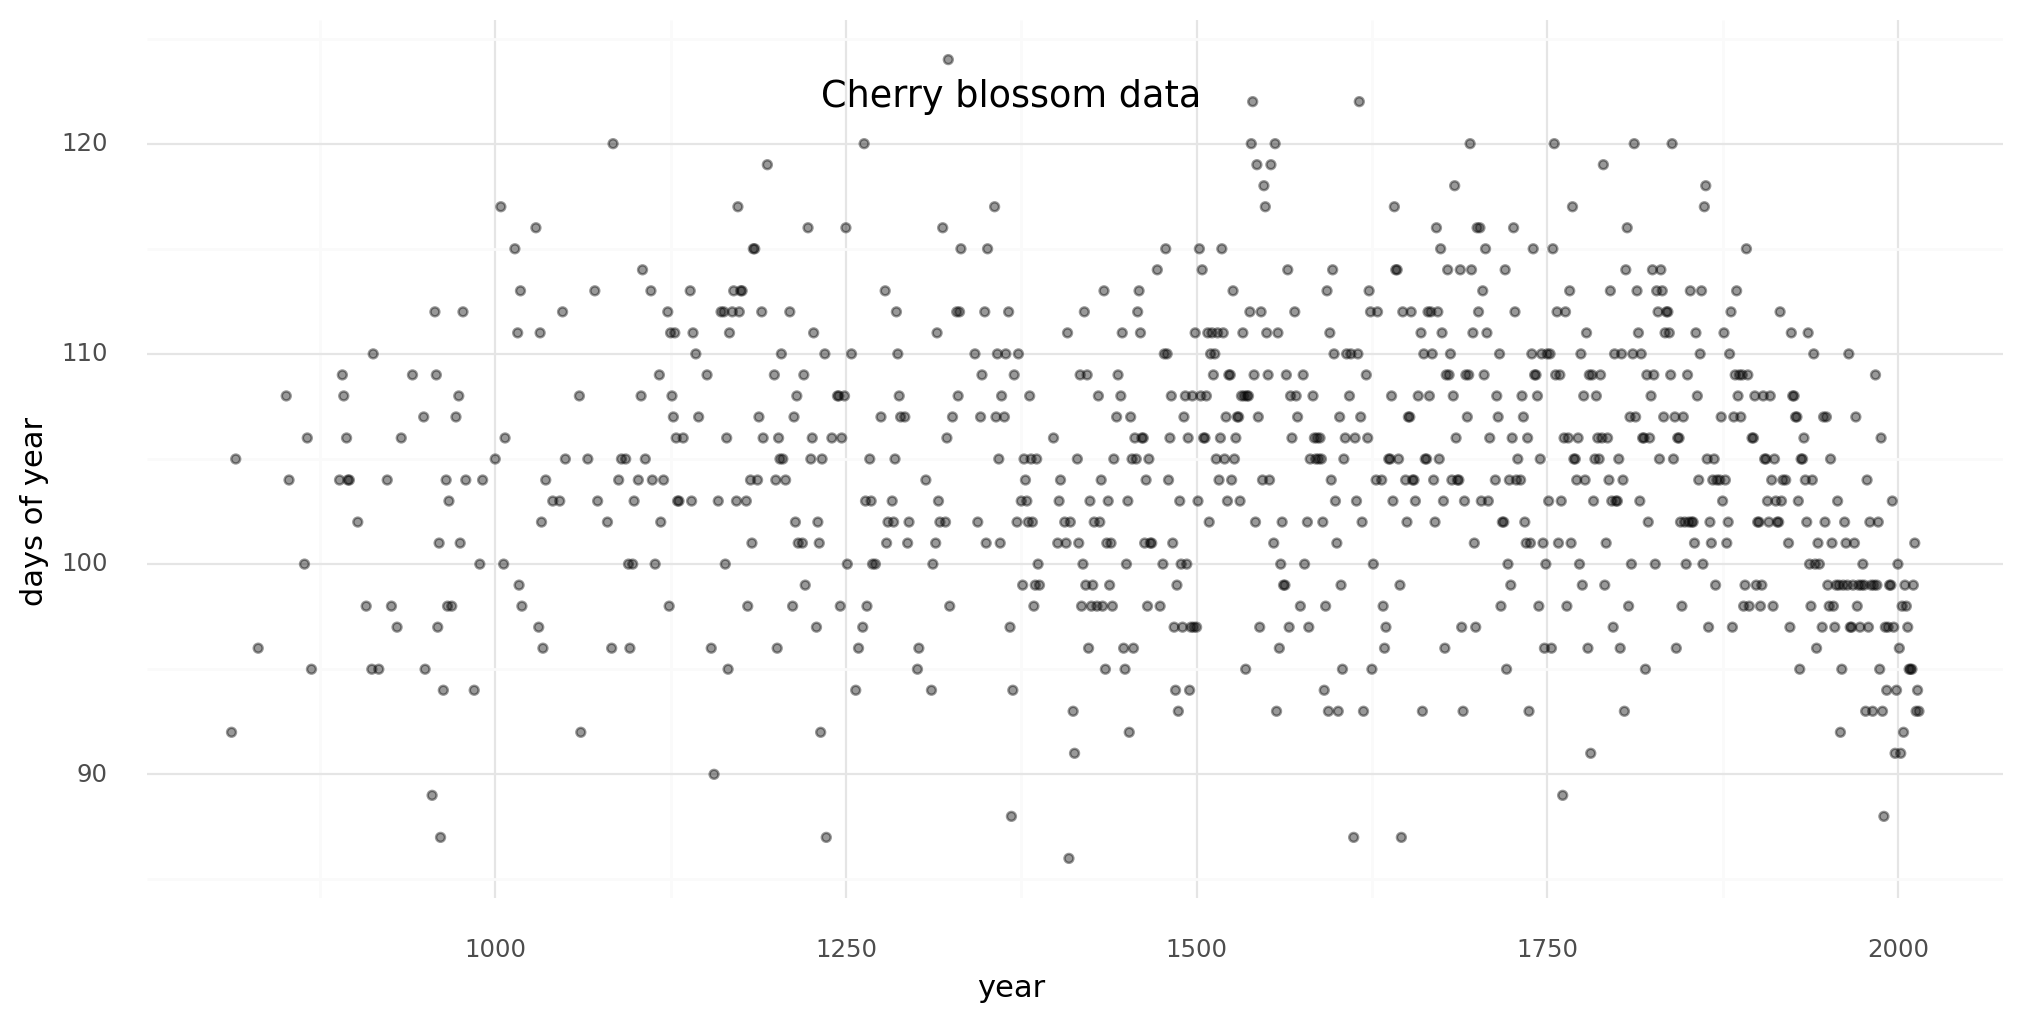

<ggplot: (353753338)>

In [7]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data")
)

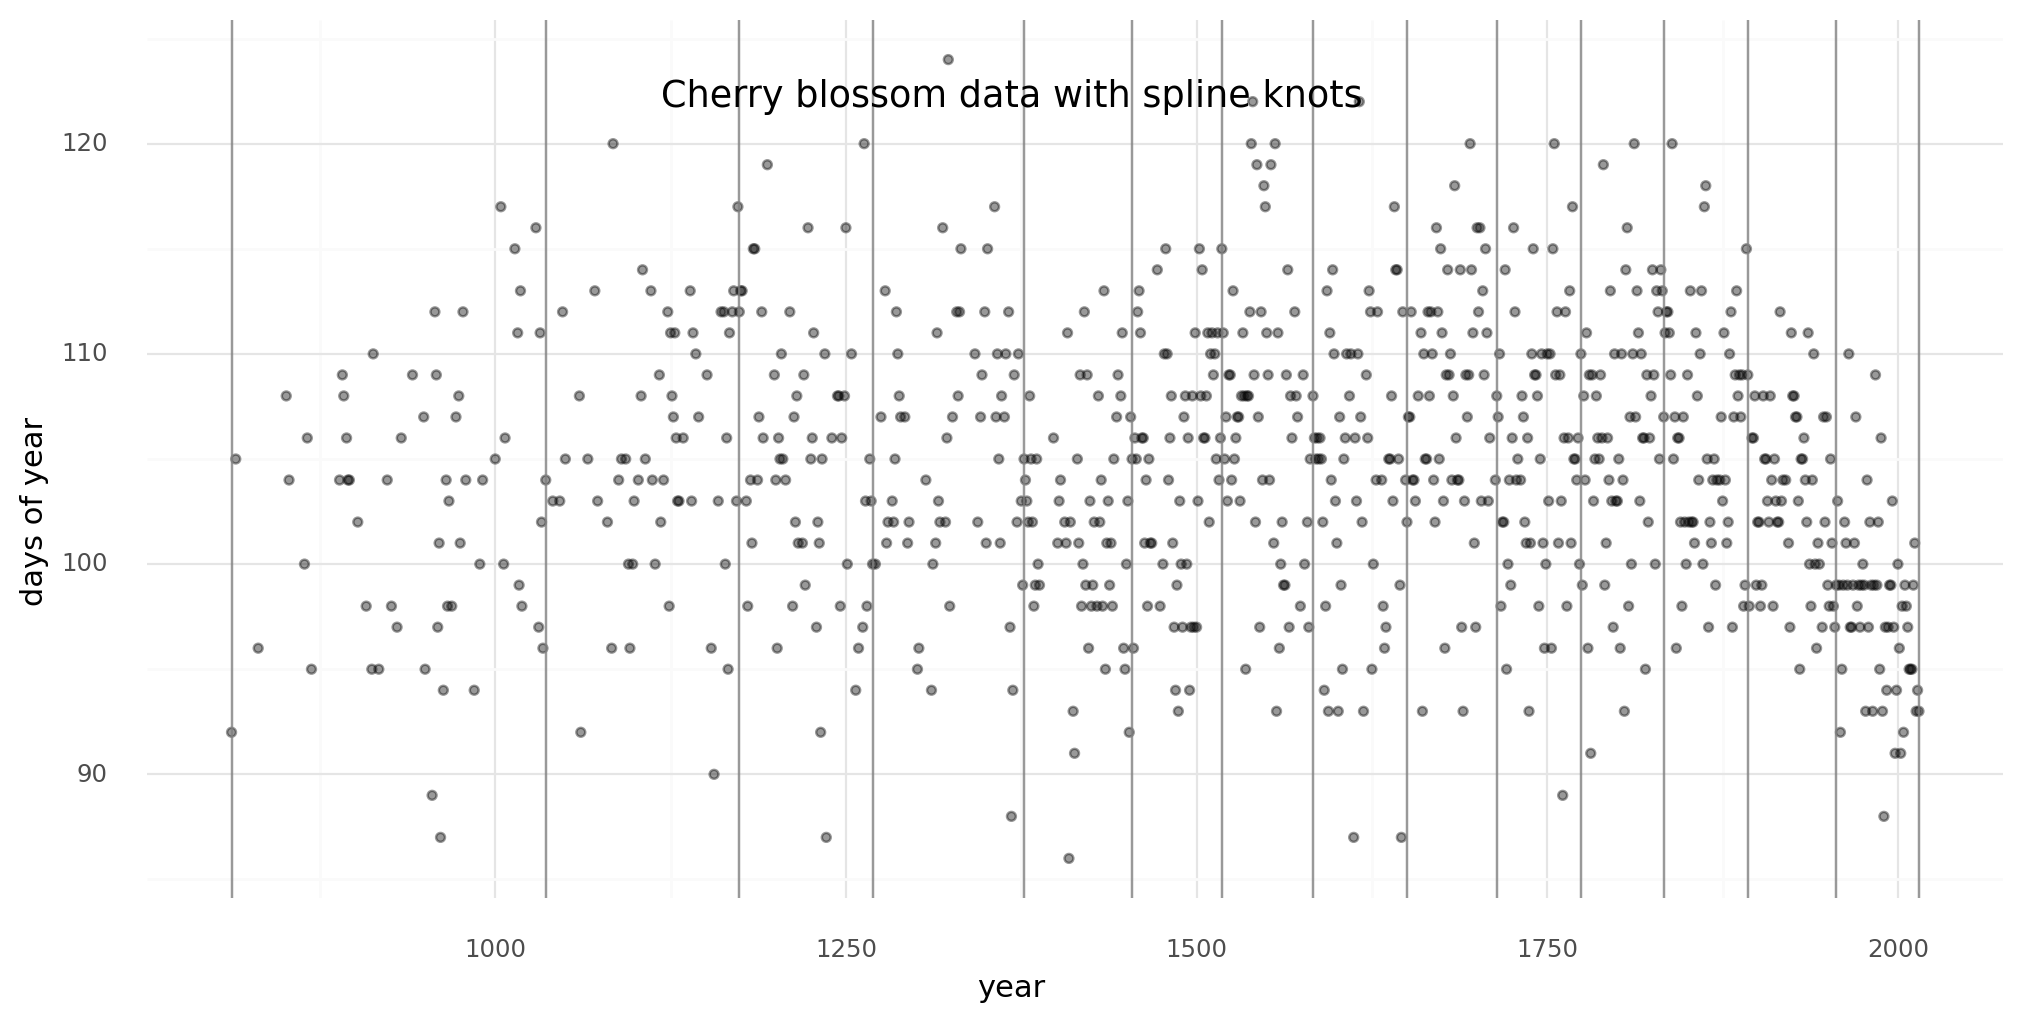

<ggplot: (353837276)>

In [8]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

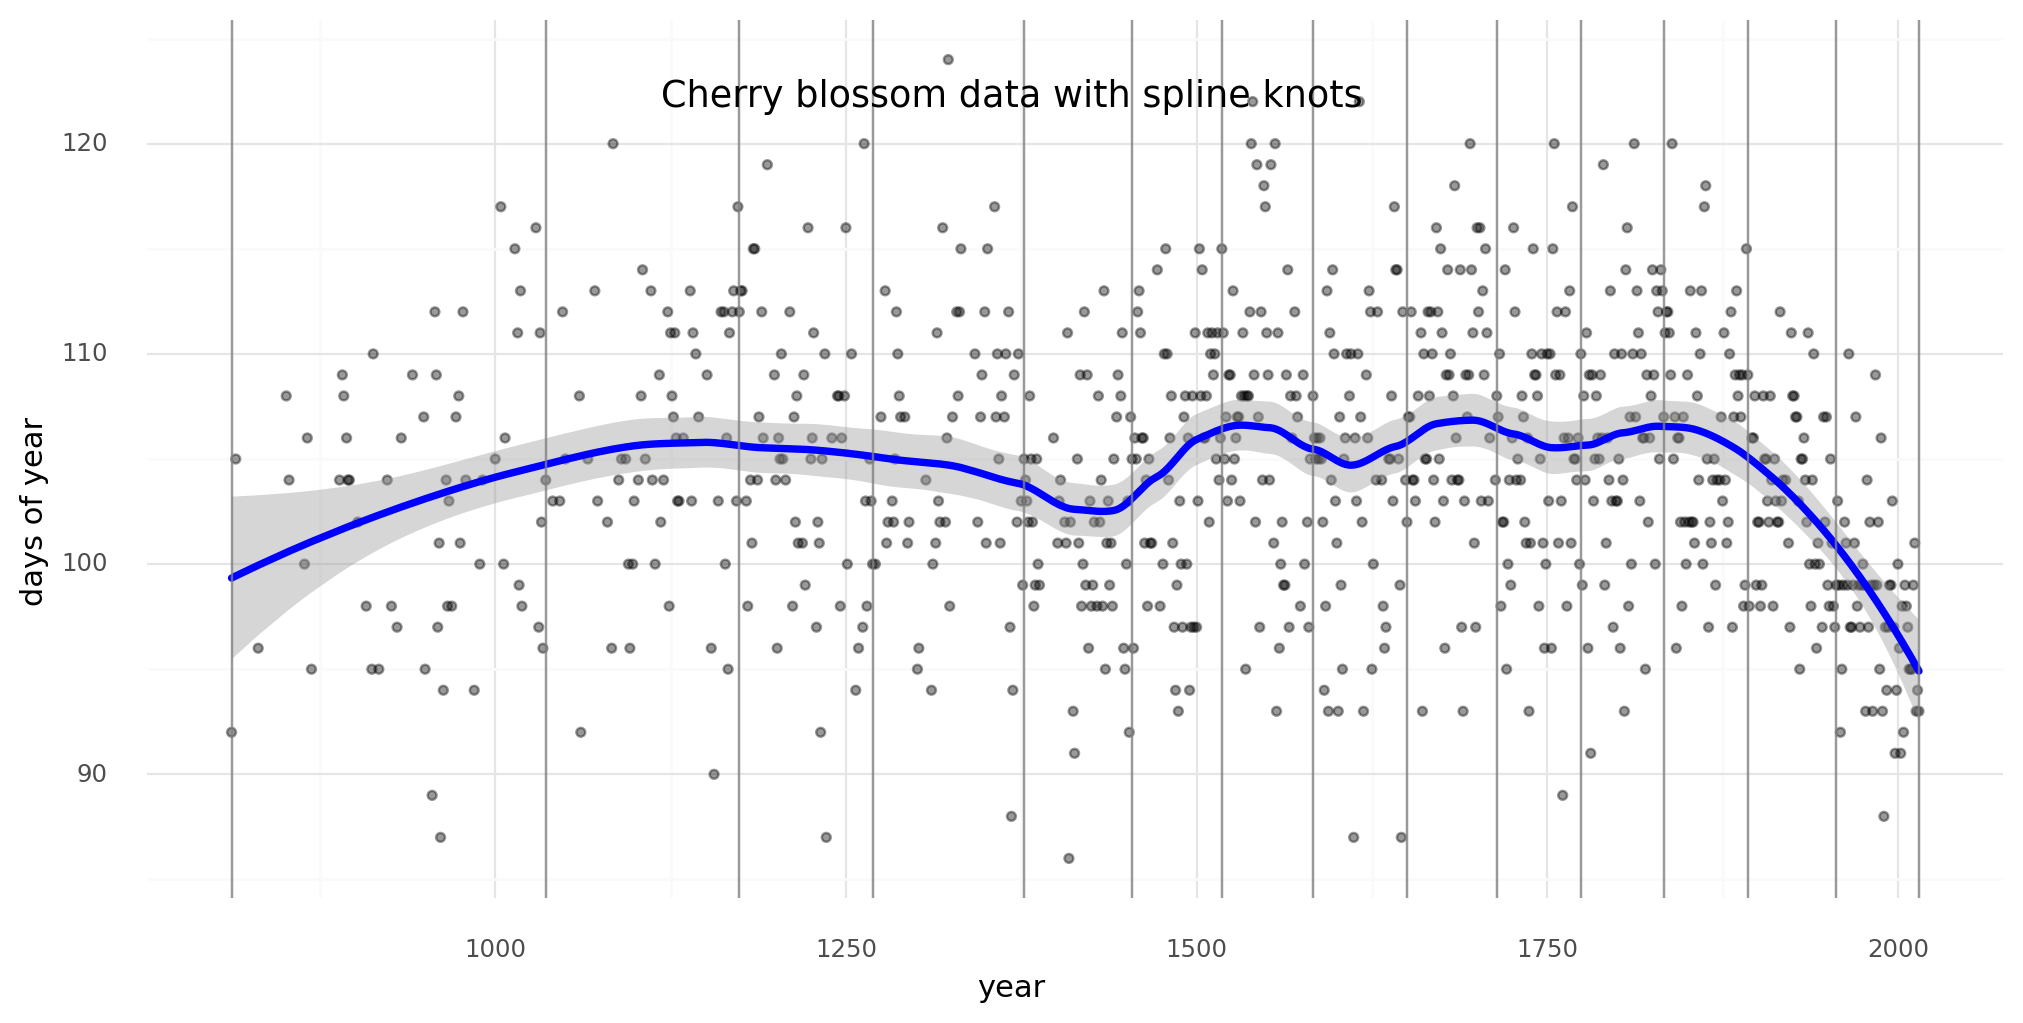

<ggplot: (353871767)>

In [9]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_smooth(method="loess", span=0.3, size=1.5, color="blue", linetype="-")
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

In [10]:
d2["knot_group"] = [np.where(a <= knot_list)[0][0] for a in d2.year]
d2["knot_group"] = pd.Categorical(d2["knot_group"], ordered=True)

/usr/local/Caskroom/miniconda/base/envs/pymc-examples/lib/python3.9/site-packages/plotnine/stats/stat_smooth.py:201: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.


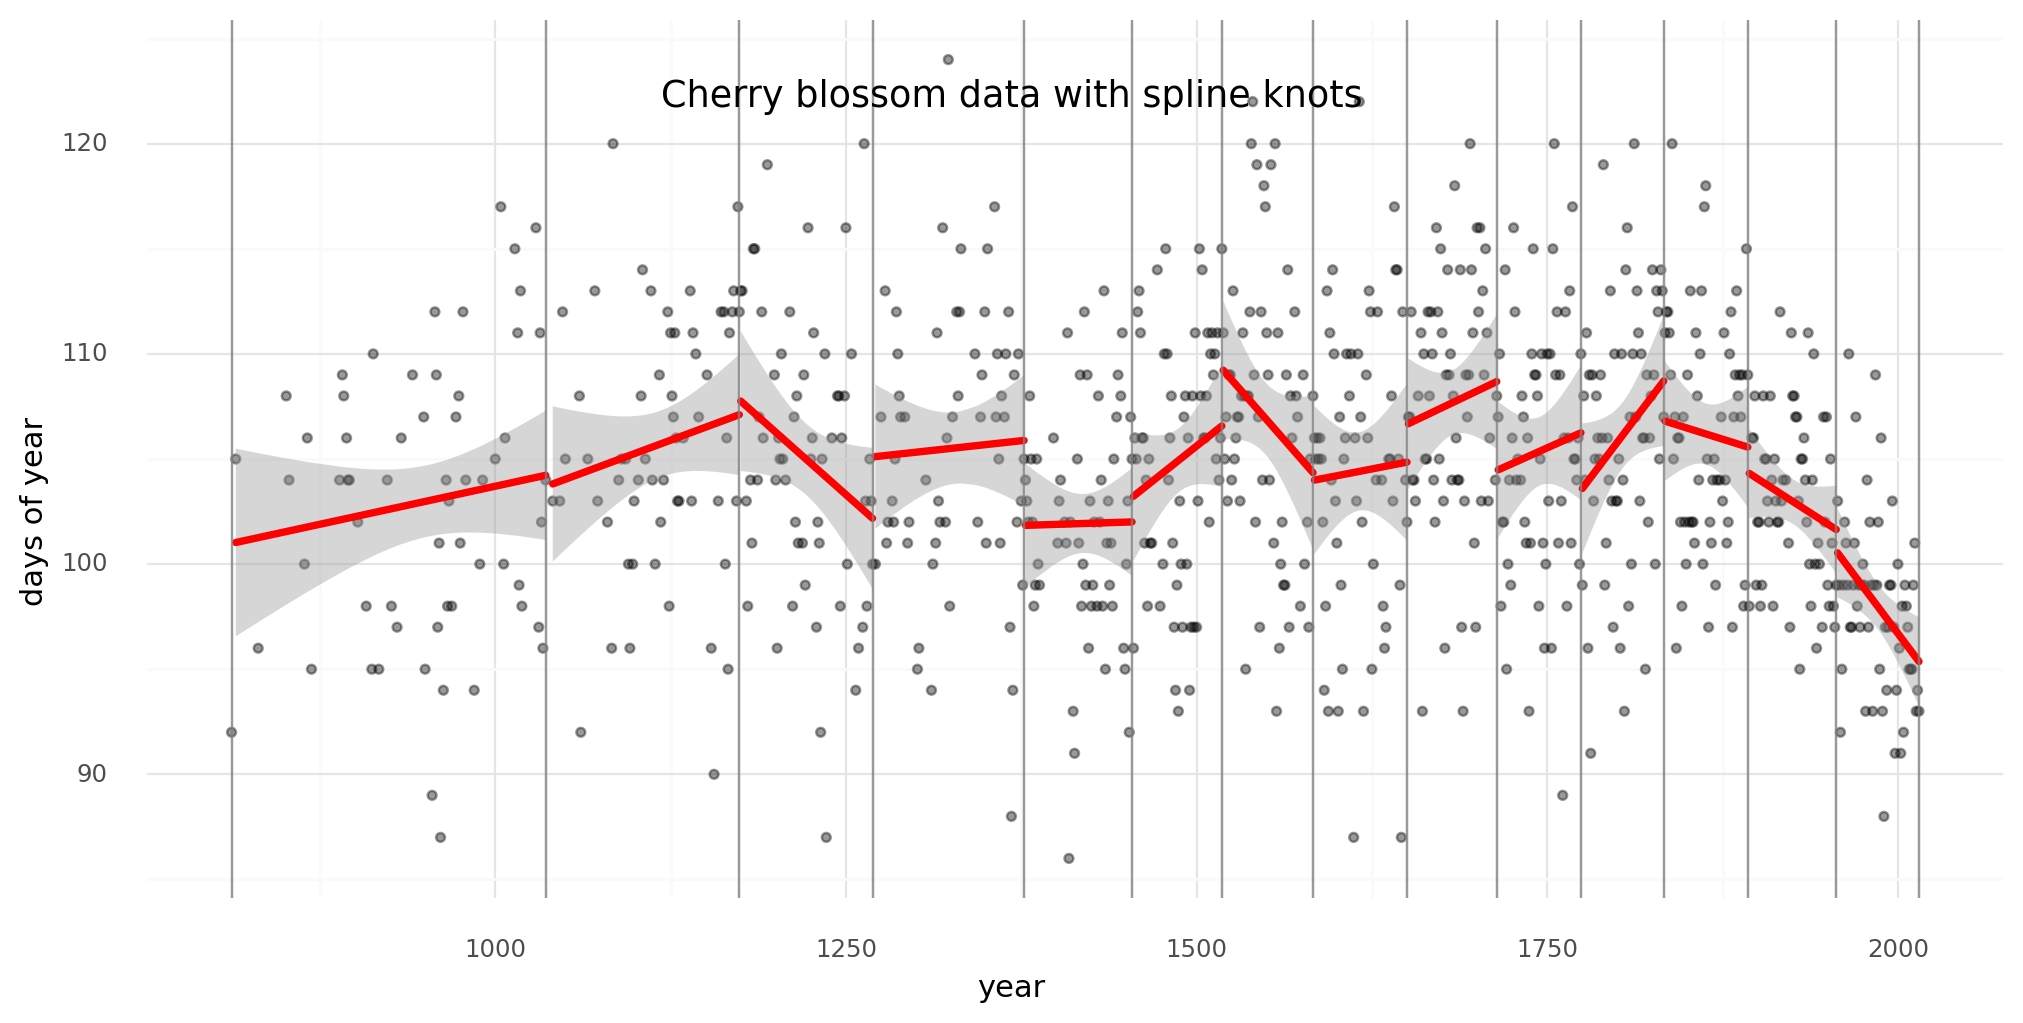

<ggplot: (353868665)>

In [11]:
(
    gg.ggplot(d2, gg.aes(x="year", y="doy"))
    + gg.geom_point(color="black", alpha=0.4, size=1.3)
    + gg.geom_smooth(gg.aes(group="knot_group"), method="lm", size=1.5, color="red", linetype="-")
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="days of year", title="Cherry blossom data with spline knots")
)

In [12]:
B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True) - 1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (827, 17)
  Columns:
    ['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
     'bs(year, knots=knots, degree=3, include_intercept=True)[13]',
     'bs(year

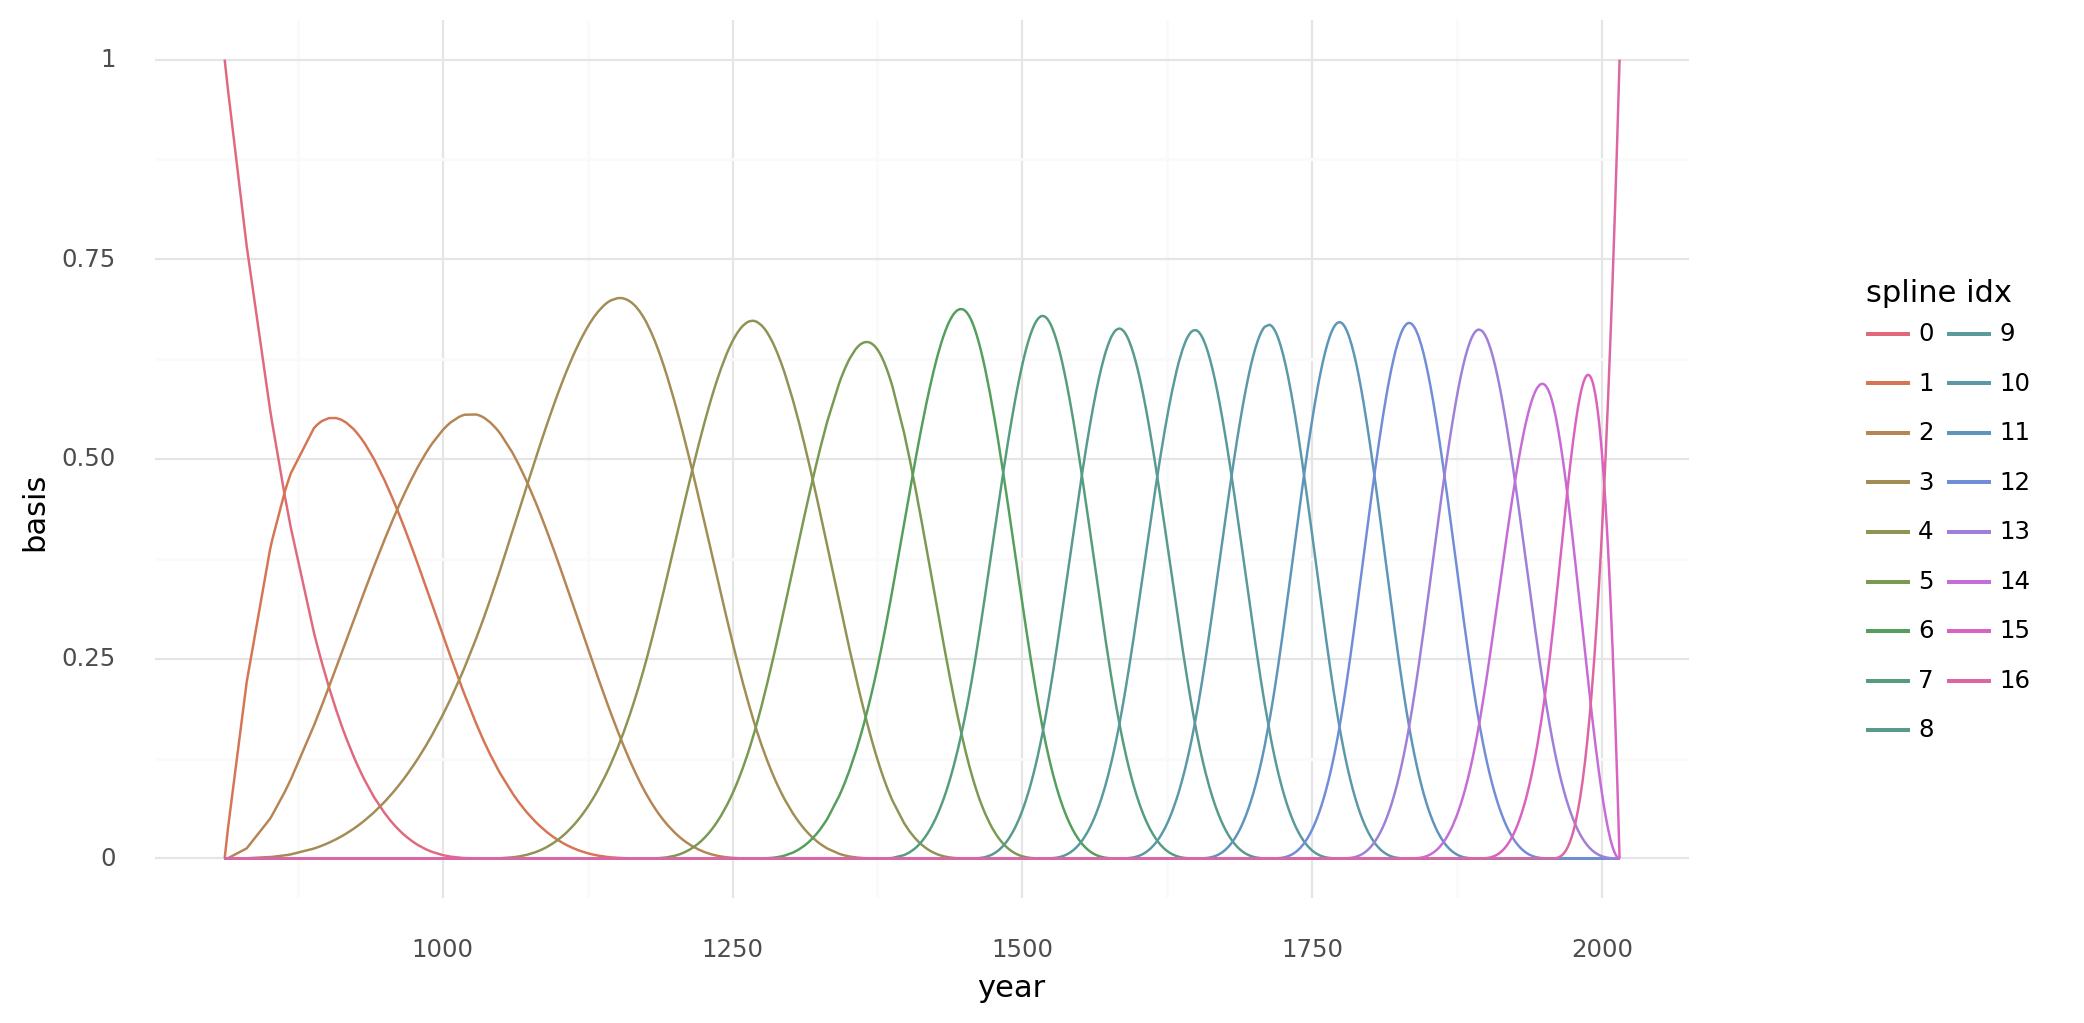

<ggplot: (284630803)>

In [13]:
spline_df = (
    pd.DataFrame(B)
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(spline_df, gg.aes(x="year", y="value"))
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"))
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2), color_space="husl")
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="basis", color="spline idx")
)

In [14]:
with pm.Model() as spline_model:
    a = pm.Normal("a", 100, 5)
    w = pm.Normal("w", mu=0, sd=3, shape=B.shape[1])
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu, sigma, observed=d2.doy)

**Make sure to note that producing the graph requires `python-graphviz` library; easiest to get from conda.**

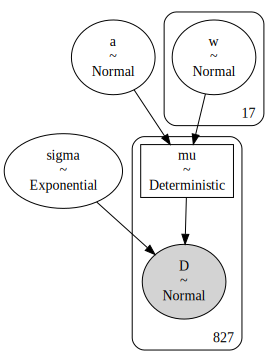

In [15]:
pm.model_to_graphviz(spline_model)

In [16]:
with spline_model:
    prior_pred = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    trace = pm.sample(
        draws=1000,
        tune=1000,
        random_seed=RANDOM_SEED,
        chains=4,
        return_inferencedata=True,
    )
    post_pred = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)
    trace.extend(az.from_pymc3(prior=prior_pred, posterior_predictive=post_pred))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, w, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 52 seconds.


In [17]:
az.summary(trace, var_names=["a", "w", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,103.667,0.761,102.226,105.030,0.017,0.012,1927.0,2323.0,1.0
w[0],-1.781,2.252,-6.273,2.137,0.036,0.030,3983.0,2915.0,1.0
w[1],-1.641,2.086,-5.634,2.086,0.038,0.029,3065.0,2852.0,1.0
w[2],-0.306,1.912,-4.071,3.178,0.034,0.028,3076.0,2784.0,1.0
w[3],3.316,1.440,0.751,6.148,0.026,0.019,3042.0,3278.0,1.0
w[4],0.145,1.513,-2.660,2.958,0.026,0.021,3333.0,3160.0,1.0
w[5],2.089,1.574,-0.711,5.194,0.029,0.021,3030.0,2983.0,1.0
w[6],-3.615,1.413,-6.264,-0.958,0.026,0.018,2949.0,3119.0,1.0
w[7],5.506,1.516,2.527,8.206,0.027,0.020,3102.0,2525.0,1.0
w[8],-0.081,1.505,-2.834,2.817,0.028,0.021,2953.0,3332.0,1.0


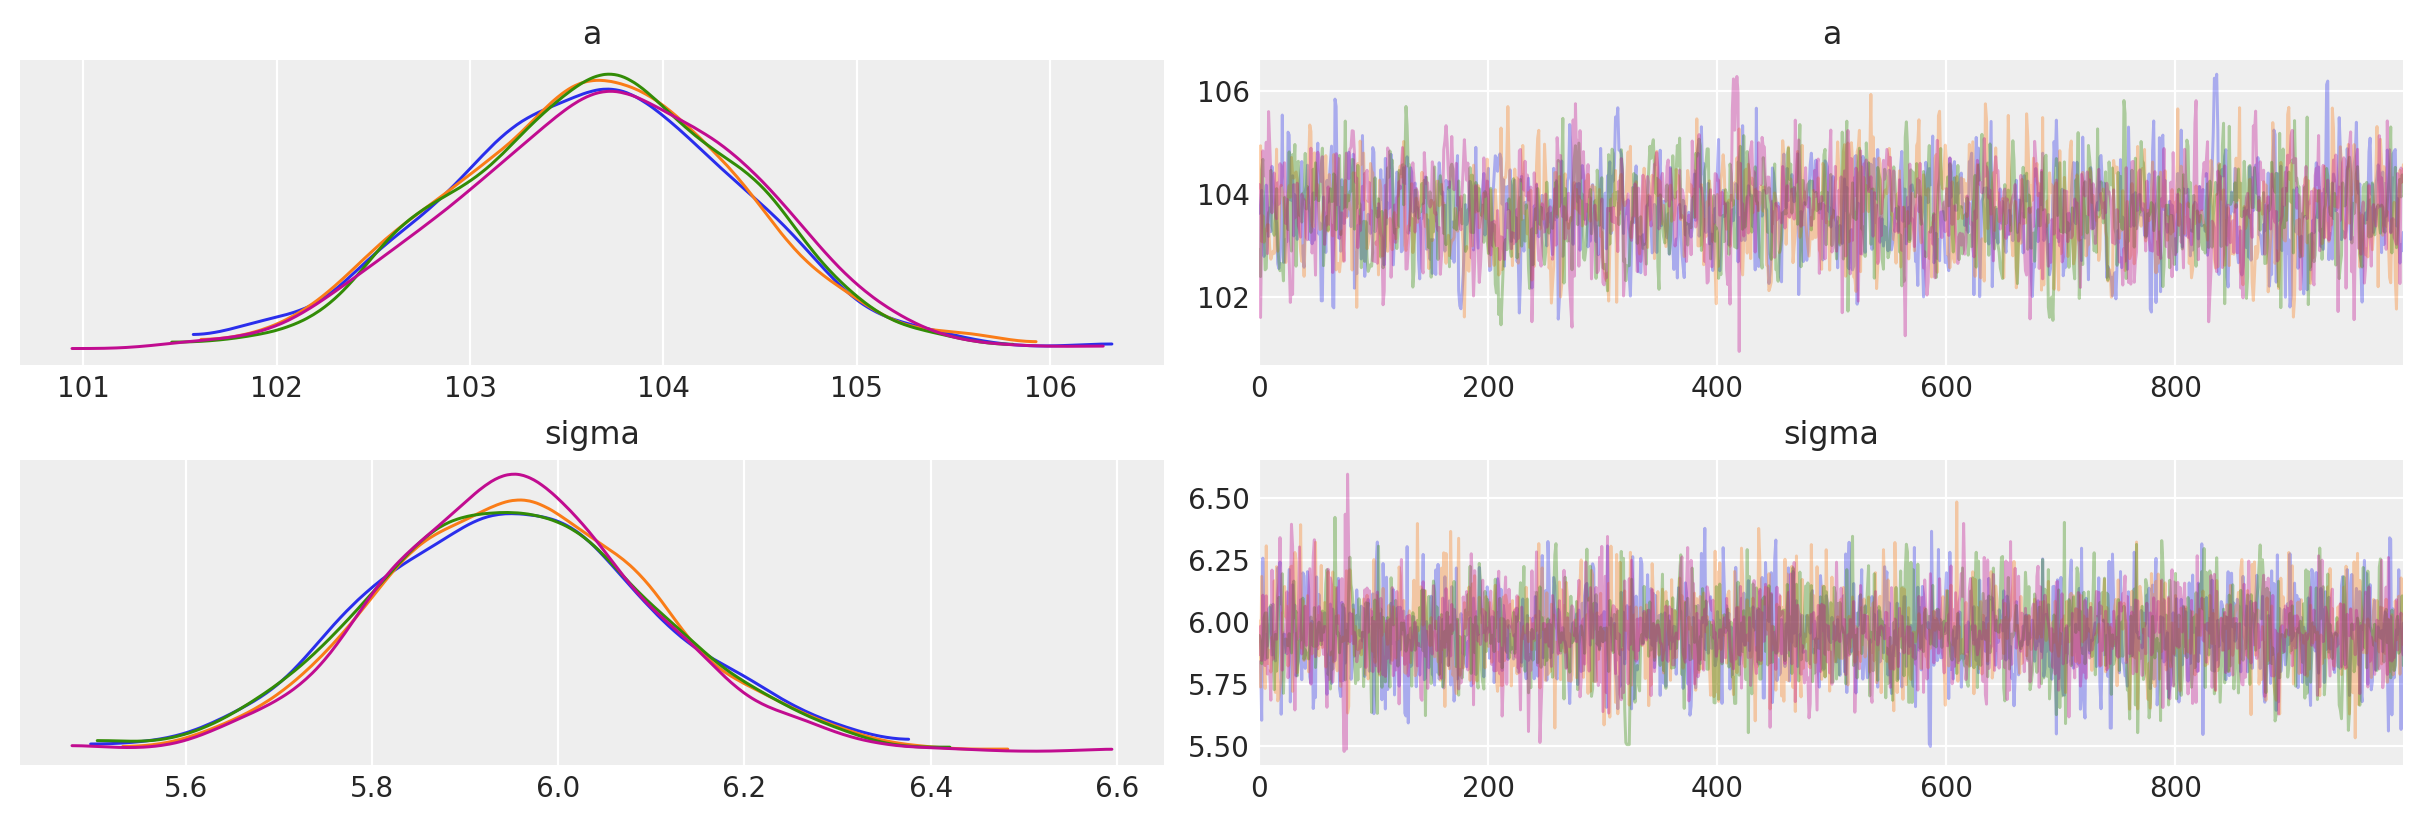

In [18]:
az.plot_trace(trace, var_names=["a", "sigma"], compact=False);

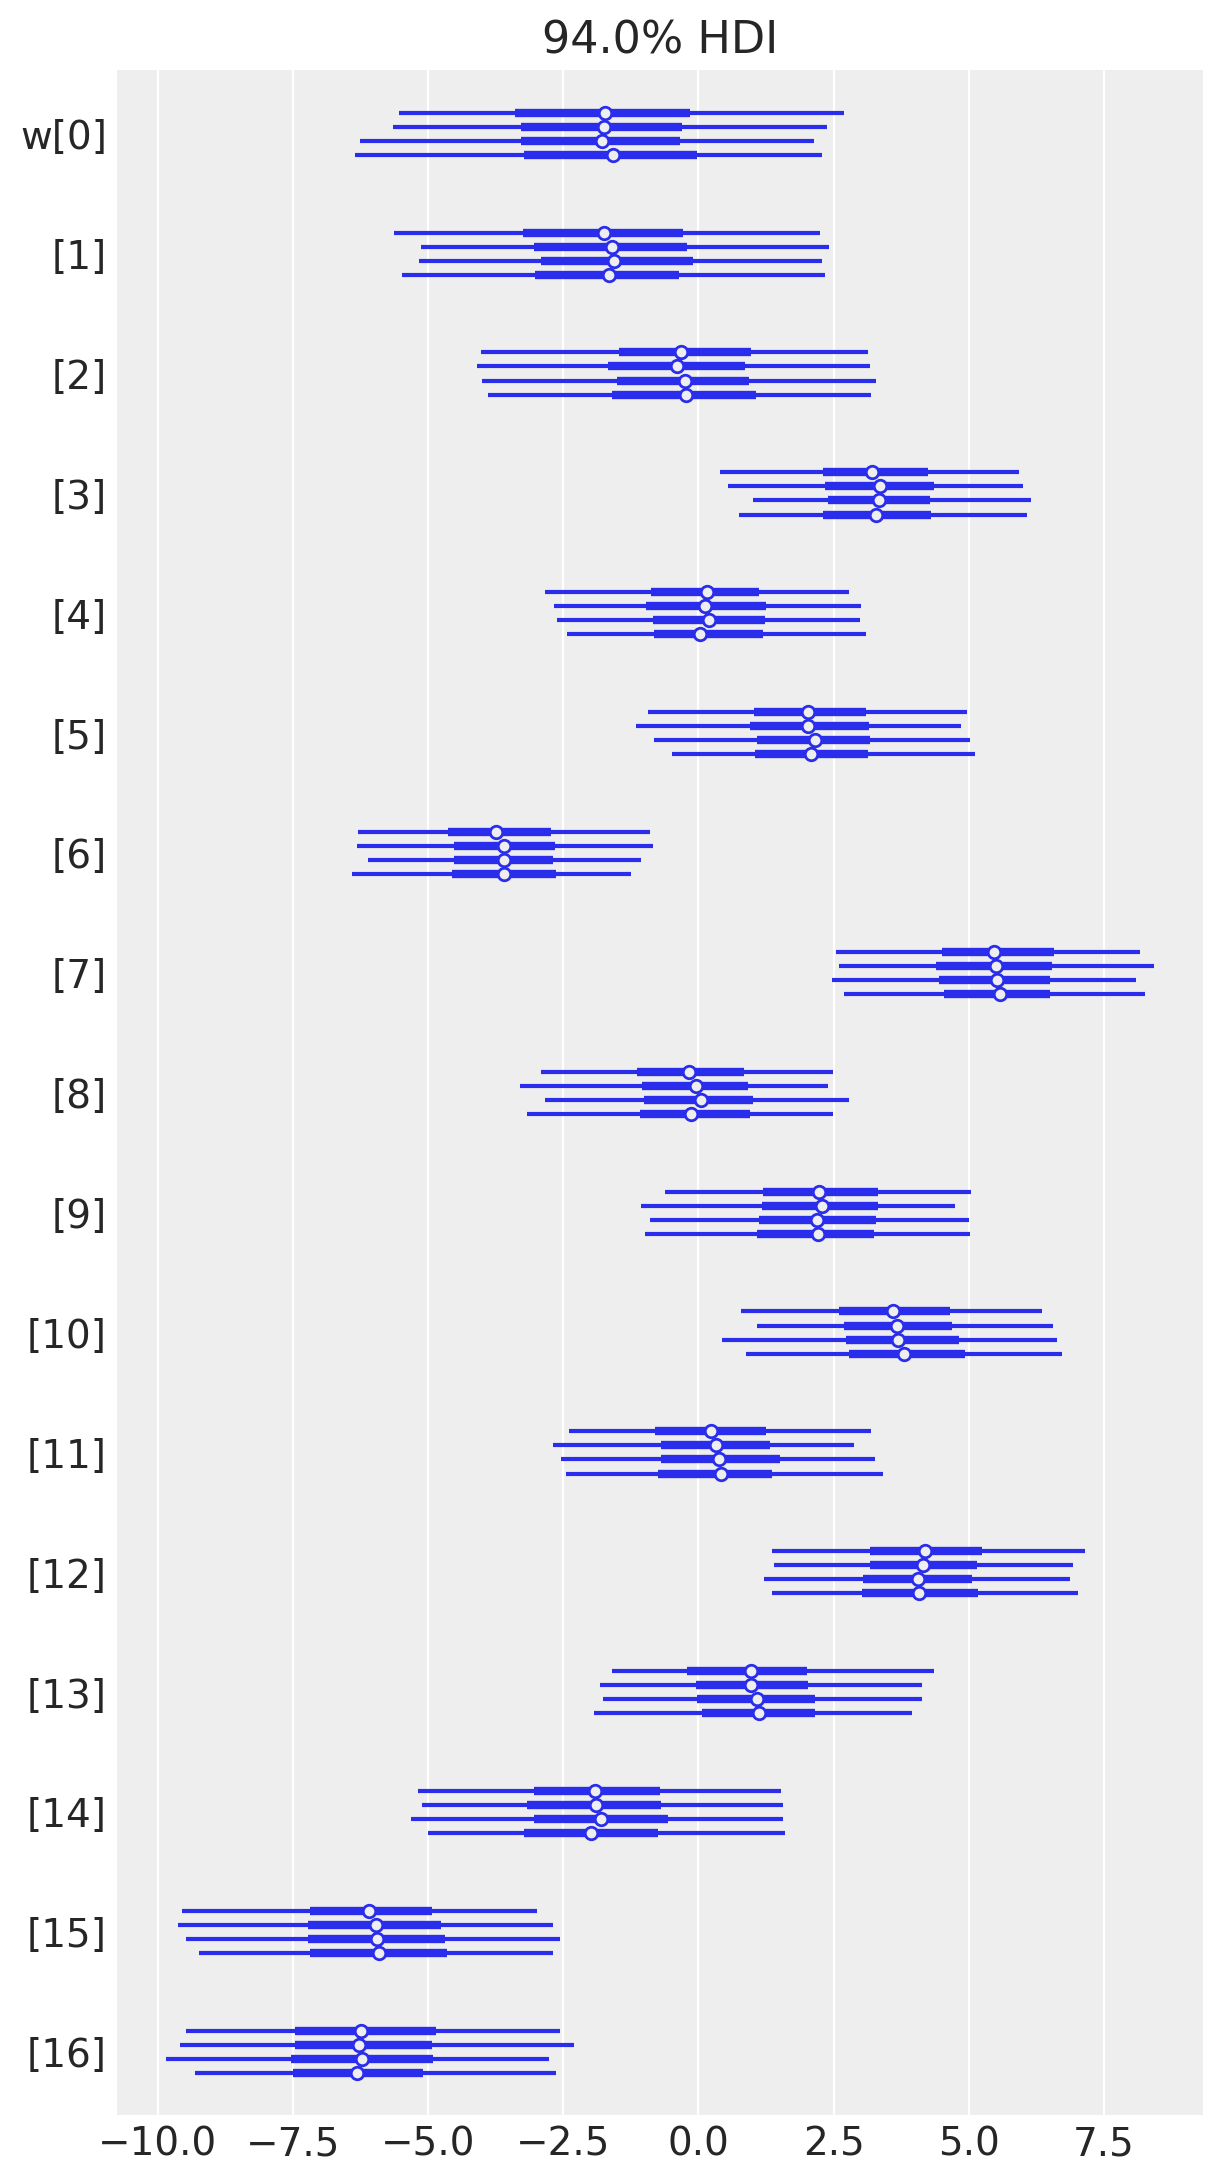

In [19]:
az.plot_forest(trace, var_names=["w"], combined=False);

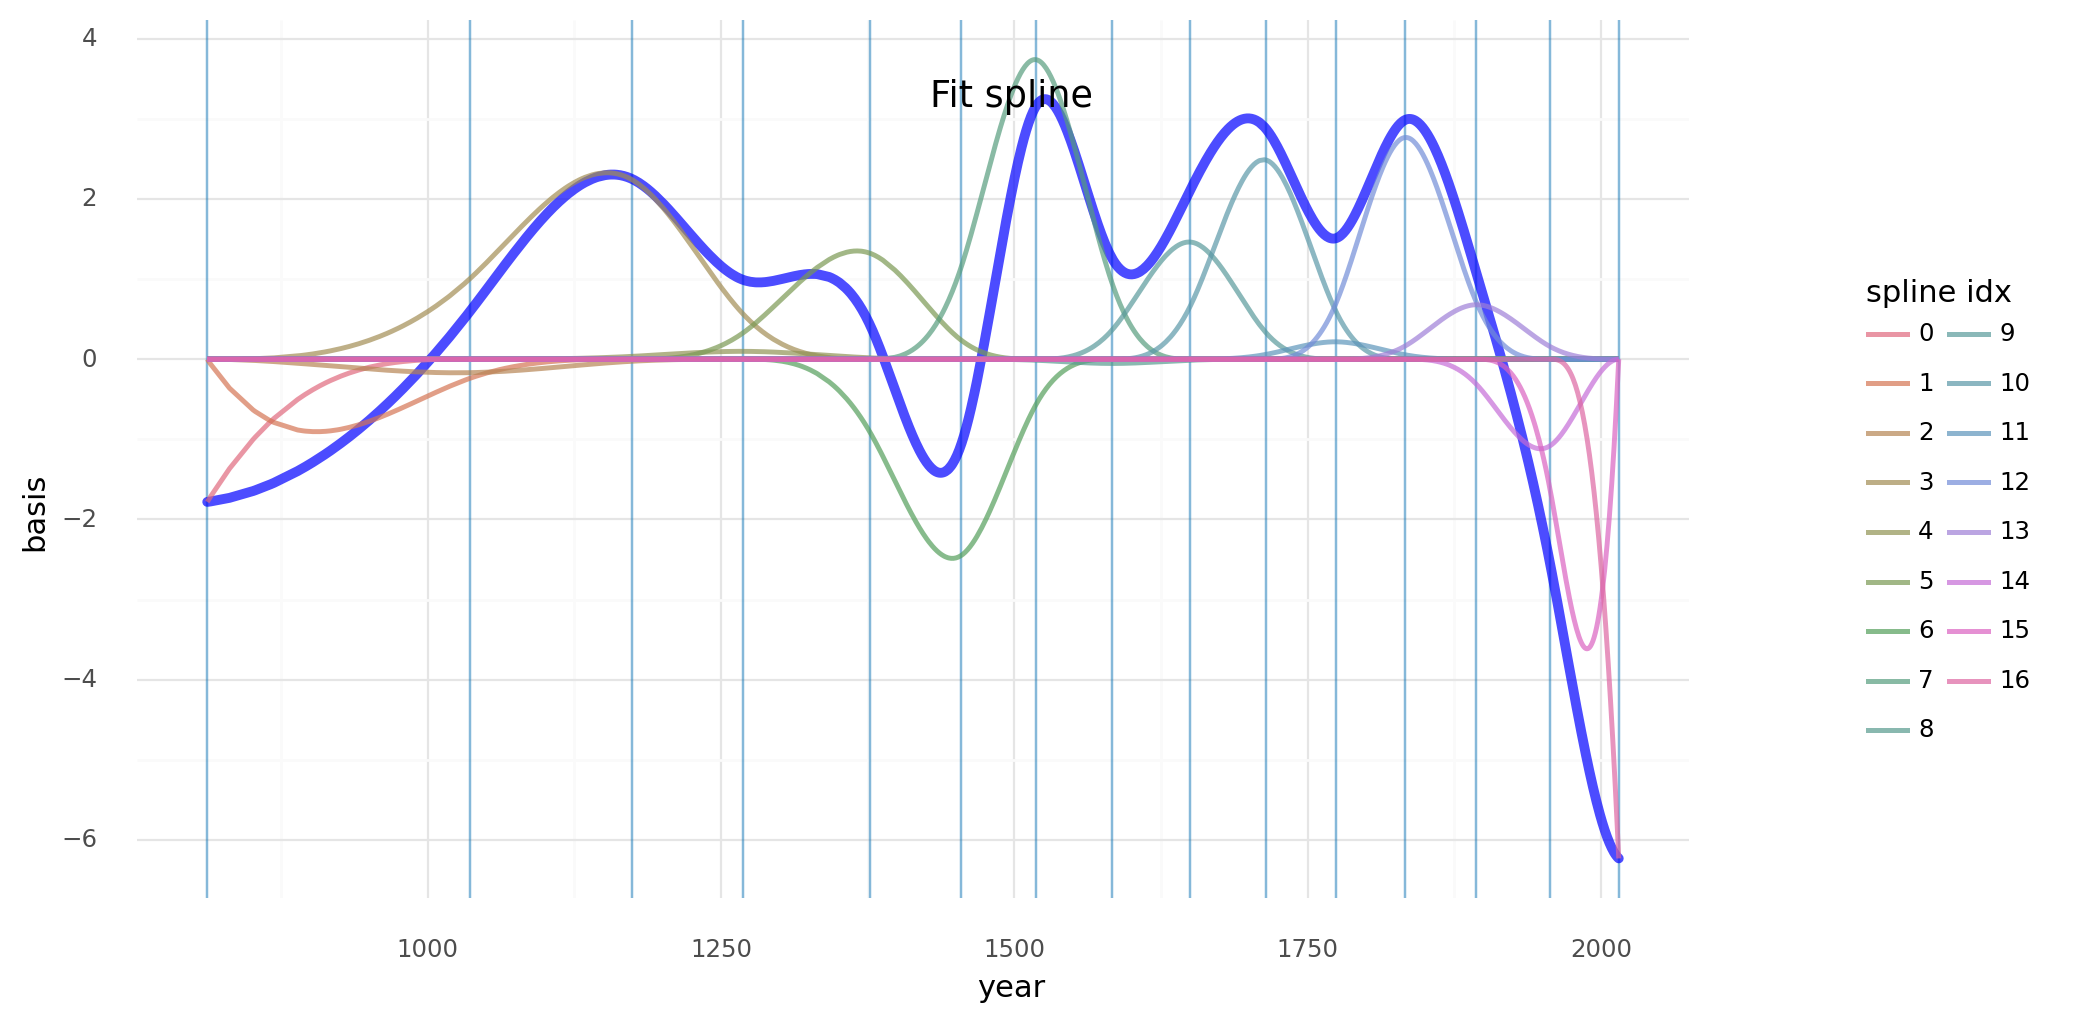

<ggplot: (361617131)>

In [20]:
wp = trace.posterior["w"].values.mean(axis=(0, 1))

spline_df = (
    pd.DataFrame(B * wp.T)
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(year=d2.year.values)
    .melt("year", var_name="spline_i", value_name="value")
)

(
    gg.ggplot(spline_df, gg.aes(x="year", y="value"))
    + gg.geom_vline(xintercept=knot_list, color="#0C73B4", alpha=0.5)
    + gg.geom_line(data=spline_df_merged, linetype="-", color="blue", size=2, alpha=0.7)
    + gg.geom_line(gg.aes(group="spline_i", color="spline_i"), alpha=0.7, size=1)
    + gg.scale_color_discrete(guide=gg.guide_legend(ncol=2), color_space="husl")
    + gg.theme(figure_size=(10, 5))
    + gg.labs(x="year", y="basis", title="Fit spline", color="spline idx")
)

In [21]:
post_pred = az.summary(trace, var_names=["mu"]).reset_index(drop=True)
d2_post = d2.copy().reset_index(drop=True)
d2_post["pred_mean"] = post_pred["mean"]
d2_post["pred_hdi_lower"] = post_pred["hdi_3%"]
d2_post["pred_hdi_upper"] = post_pred["hdi_97%"]

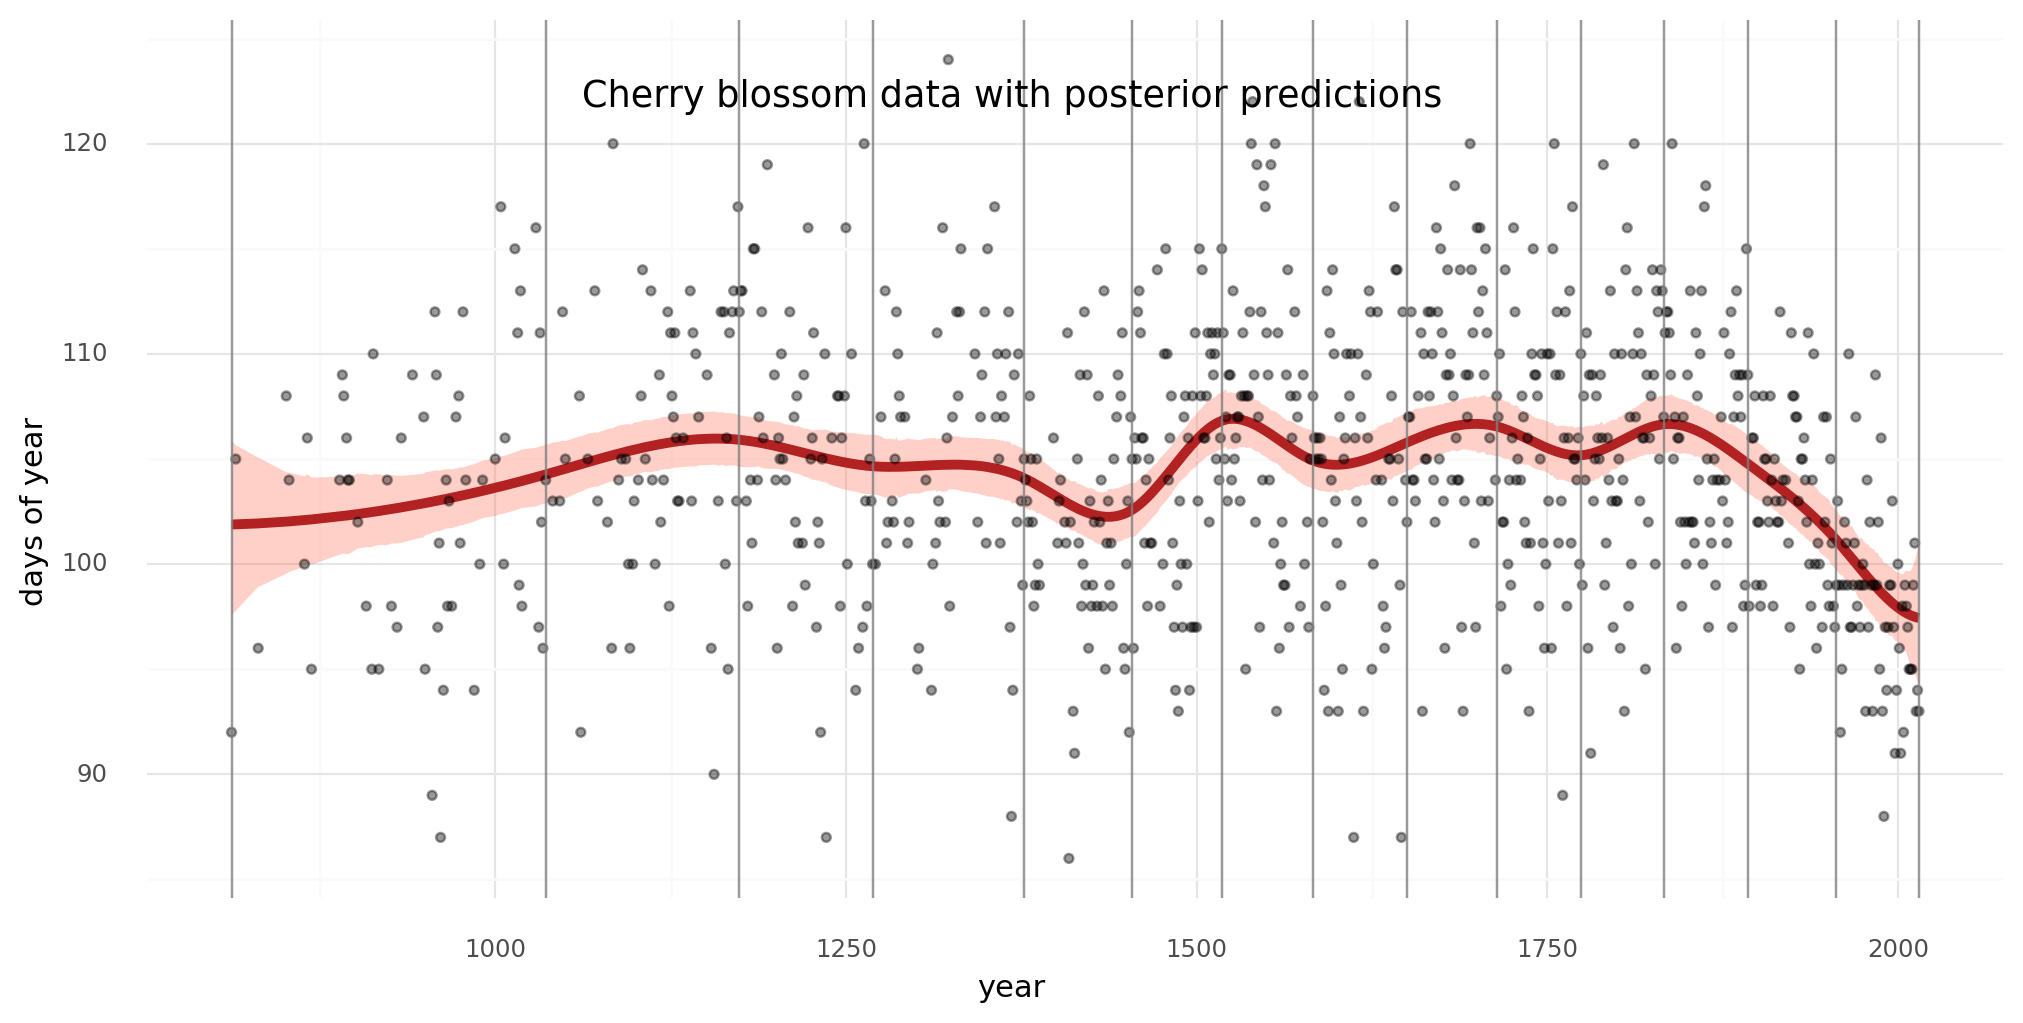

<ggplot: (362079693)>

In [22]:
(
    gg.ggplot(d2_post, gg.aes(x="year"))
    + gg.geom_ribbon(gg.aes(ymin="pred_hdi_lower", ymax="pred_hdi_upper"), alpha=0.3, fill="tomato")
    + gg.geom_line(gg.aes(y="pred_mean"), color="firebrick", alpha=1, size=2)
    + gg.geom_point(gg.aes(y="doy"), color="black", alpha=0.4, size=1.3)
    + gg.geom_vline(xintercept=knot_list, color="gray", alpha=0.8)
    + gg.theme(figure_size=(10, 5))
    + gg.labs(
        x="year",
        y="days of year",
        title="Cherry blossom data with posterior predictions",
    )
)

---

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Sat Oct 02 2021

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 7.28.0

theano: 1.1.2
xarray: 0.19.0

pymc3   : 3.11.4
numpy   : 1.21.2
pandas  : 1.3.3
arviz   : 0.11.3
plotnine: 0.8.0

Watermark: 2.2.0



In [24]:
!conda list scikit-misc && conda list python-graphviz

# packages in environment at /usr/local/Caskroom/miniconda/base/envs/pymc-examples:
#
# Name                    Version                   Build  Channel
scikit-misc               0.1.3            py39h9ca4c2c_2    conda-forge
# packages in environment at /usr/local/Caskroom/miniconda/base/envs/pymc-examples:
#
# Name                    Version                   Build  Channel
python-graphviz           0.17               pyhaef67bd_0    conda-forge
